In [1]:
import torch
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import style
style.use('dark_background')


import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH = '/home/irina/Documents/PROJECTS/excursion' 

# Initialize GP with truth-level data 

## Load and clean data

In [2]:
data_exp = pd.read_csv("./data/limit_expected_values.csv")
data_obs = pd.read_csv("./data/limit_observed_values.csv")
data_exp = data_exp.rename(columns={"limit": "limit_exp"})
data_obs = data_obs.rename(columns={"limit": "limit_obs"})

print('Expected')
print(data_exp.describe())
print('Observed')
print(data_obs.describe())

#join data
data =  pd.merge(left=data_exp, right=data_obs, how='left', left_on=['mzp','mdh'], right_on = ['mzp','mdh'])
print('All data')
print(data.describe())



Expected
               mzp         mdh  limit_exp
count    42.000000   42.000000  42.000000
mean   2000.000000  100.000000   0.704990
std    1012.121655   34.570536   1.017148
min     500.000000   50.000000   0.057970
25%    1000.000000   70.000000   0.114064
50%    2000.000000  100.000000   0.268355
75%    3000.000000  130.000000   0.835135
max    3500.000000  150.000000   4.659425
Observed
               mzp         mdh  limit_obs
count    42.000000   42.000000  42.000000
mean   2000.000000  100.000000   1.089037
std    1012.121655   34.570536   1.761831
min     500.000000   50.000000   0.054571
25%    1000.000000   70.000000   0.144182
50%    2000.000000  100.000000   0.396710
75%    3000.000000  130.000000   1.080801
max    3500.000000  150.000000   9.345449
All data
               mzp         mdh  limit_exp  limit_obs
count    42.000000   42.000000  42.000000  42.000000
mean   2000.000000  100.000000   0.704990   1.089037
std    1012.121655   34.570536   1.017148   1.761831
min  

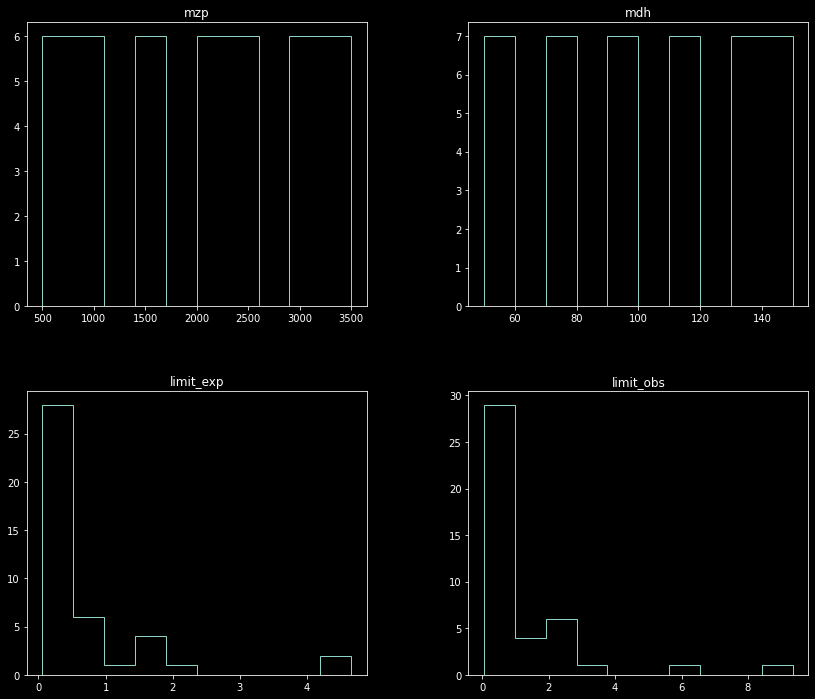

In [3]:
data.hist(figsize=(14,12), histtype='step', grid=False);

In [4]:

parameters = ['mzp','mdh'] #mdm=200
targets = ['limit_obs']

In [ ]:
f = plt.figure(figsize=(8, 6))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);


In [ ]:
import seaborn as sns
g = sns.pairplot(data, diag_kind="hist",  \
                plot_kws=dict(marker="o", s=5, alpha=0.9, linestyles=[":"]),\
                 height=2.5)

g.map_lower(sns.kdeplot, levels=4, alpha=0.7, color='white')
g.savefig("pairplot_raw_data.pdf")

In [6]:
# convert to tensor after exploration
input_tensor = torch.tensor(data[parameters].values, dtype=torch.float32, requires_grad=True) #will require grad for our analysis
target_tensor = torch.tensor(data[targets].values, dtype=torch.float32, requires_grad=True).view(-1) #will require grad for our analysis
print('input tensor ', input_tensor.shape)
print('target tensor ', target_tensor.shape)

input tensor  torch.Size([42, 2])
target tensor  torch.Size([42])


In [8]:
# split train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_tensor, target_tensor, test_size=0.1, random_state=42)
print('train: ', len(X_train))
print('test: ', len(X_test))

#normalize X
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train.detach().numpy())
X_train = torch.Tensor(scaler.transform(X_train.detach().numpy()))
print(X_train.shape)
X_test = torch.Tensor(scaler.transform(X_test.detach().numpy()))

train:  37
test:  5
torch.Size([37, 2])


## Define GP model to use

In [9]:
import gpytorch

#class MultitaskGPModel(gpytorch.models.ExactGP):
#    def __init__(self, train_x, train_y, likelihood):
#        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
#        self.mean_module = gpytorch.means.MultitaskMean(
#            gpytorch.means.ConstantMean(), num_tasks=2
#        )
#        self.covar_module = gpytorch.kernels.MultitaskKernel(
#            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
#        )
#
#    def forward(self, x):
#        mean_x = self.mean_module(x)
#        covar_x = self.covar_module(x)
#        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

#class SpectralMixtureGPModel(gpytorch.models.ExactGP):
#    def __init__(self, train_x, train_y, likelihood):
#        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
#        self.mean_module = gpytorch.means.ConstantMean()
#        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=2, ard_num_dims=2)
#        print('train_x device ', train_x.device)
#        print('train_y device ', train_y.device)
#        self.covar_module.initialize_from_data(train_x, train_y)
#
#    def forward(self,x):
#        mean_x = self.mean_module(x)
#        covar_x = self.covar_module(x)
#        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Train the model

In [10]:
# initialize likelihood and model    

X_train = X_train.to(device) 
y_train = y_train.to(device)

#likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood = likelihood.to(device)

print(X_train.shape, y_train.shape)
model = ExactGPModel(X_train, y_train, likelihood)
# to cuda
model = model.to(device)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # Includes GaussianLikelihood parameters
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)  # Includes GaussianLikelihood parameters


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
SAVE_PATH = './best_model_sensitivity_MultiOut.pth' #to save models

training_iterations = 4000
best_loss = 1E10
losses = []
hyperparams = []

print('X', X_train.shape)
print('y', y_train.view(-1).shape)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train) 
    loss = -mll(output, y_train.view(-1)) # .contiguous() #avoid running into shape error
    loss.backward(retain_graph=True)
    losses.append(loss.item())
    hyperparams.append(model.parameters())
    if(i%100==0):
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    #save model
    if(loss < best_loss):
        best_loss = loss
        torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, SAVE_PATH)
    
    optimizer.step()

torch.Size([37, 2]) torch.Size([37])
X torch.Size([37, 2])
y torch.Size([37])
Iter 1/4000 - Loss: 2.268
Iter 101/4000 - Loss: 1.879
Iter 201/4000 - Loss: 1.815
Iter 301/4000 - Loss: 1.785
Iter 401/4000 - Loss: 1.763
Iter 501/4000 - Loss: 1.745
Iter 601/4000 - Loss: 1.732
Iter 701/4000 - Loss: 1.721
Iter 801/4000 - Loss: 1.713
Iter 901/4000 - Loss: 1.706
Iter 1001/4000 - Loss: 1.700
Iter 1101/4000 - Loss: 1.695
Iter 1201/4000 - Loss: 1.691
Iter 1301/4000 - Loss: 1.688
Iter 1401/4000 - Loss: 1.684
Iter 1501/4000 - Loss: 1.682
Iter 1601/4000 - Loss: 1.679
Iter 1701/4000 - Loss: 1.677
Iter 1801/4000 - Loss: 1.674
Iter 1901/4000 - Loss: 1.672
Iter 2001/4000 - Loss: 1.671
Iter 2101/4000 - Loss: 1.669
Iter 2201/4000 - Loss: 1.667
Iter 2301/4000 - Loss: 1.666
Iter 2401/4000 - Loss: 1.665
Iter 2501/4000 - Loss: 1.663
Iter 2601/4000 - Loss: 1.662
Iter 2701/4000 - Loss: 1.661
Iter 2801/4000 - Loss: 1.660
Iter 2901/4000 - Loss: 1.659
Iter 3001/4000 - Loss: 1.658
Iter 3101/4000 - Loss: 1.657
Iter 3

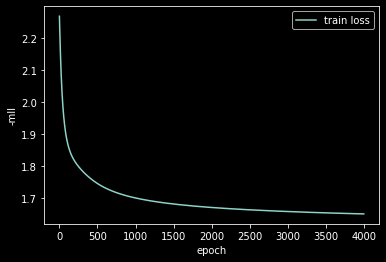

In [11]:
plt.plot(range(4000), losses, label='train loss')
plt.xlabel('epoch')
plt.ylabel('-mll')
plt.legend()

In [ ]:
for i in hyperparams[0]:
    print(i)

In [ ]:
#continue training from best model

#load best model
#LOAD_PATH = PATH + '/best_model_GP.pth'
#BEST_LOAD_PATH =  './best_model_sensitivity_MultiOut.pth'

#file = torch.load(BEST_LOAD_PATH)
#state_dict = file['model_state_dict']
#print(file)
#likelihood = gpytorch.likelihoods.GaussianLikelihood()
#model = ExactGPModel(X_train, y_train, likelihood) 
#model.load_state_dict(state_dict)


# Evaluate fit

In [14]:
model.eval()
likelihood.eval()
n = 20
test_x = torch.zeros(int(pow(n, 2)), 2)
for i in range(n):
    for j in range(n):
        test_x[i * n + j][0] = float(i) / (n-1)
        test_x[i * n + j][1] = float(j) / (n-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

In [18]:
#MAKE MESHGRID COUNTOURF    
import numpy as np
x = np.arange(501., 4000., 500)
y = np.arange(51., 160., 10)
print('len x', len(x))
print('len y', len(y))

X, Y = np.meshgrid(x, y)
print('len X', X.shape)
print('len Y', Y.shape)

test = torch.Tensor(  np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])    )

norm_test  = torch.Tensor(scaler.transform(test))
print('norm test ', norm_test.shape)

likelihood.eval()
model.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    print(model)
    f_preds_grid = model(norm_test)

    f_mean_grid = f_preds_grid.mean
    f_var_grid = f_preds_grid.variance
    f_covar_grid = f_preds_grid.covariance_matrix
    
print('f_mean  grid', f_mean_grid)

len x 7
len y 11
len X (11, 7)
len Y (11, 7)
norm test  torch.Size([77, 2])
ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (raw_outputscale_constraint): Positive()
  )
)
f_mean  grid tensor([3.5628e-01, 2.7534e-01, 3.6999e-01, 8.5940e-01, 2.0986e+00, 4.2031e+00,
        6.7375e+00, 1.8413e-01, 1.1854e-01, 1.3388e-01, 3.8486e-01, 1.2369e+00,
        2.9130e+00, 5.1364e+00, 1.0543e-01, 7.9813e-02, 5.6232e-02, 1.1481e-01,
        6.0568e-01, 1.8346e+00, 3.6806e+00, 8.8888e-02, 1.1168e-01, 8.6772e-02,
        2.4427e-02, 2.3930e-01, 1.0830e+00, 2.5599e+00, 9.7991e-02, 1.5640e-01,
        1.5364e-01, 4.9623e-02, 1.1300e-01, 6.9864e-01, 1.8853e+00, 1.0475e-01,
        1.6767e-01, 1.9216e-01, 1.1800e-01, 1.

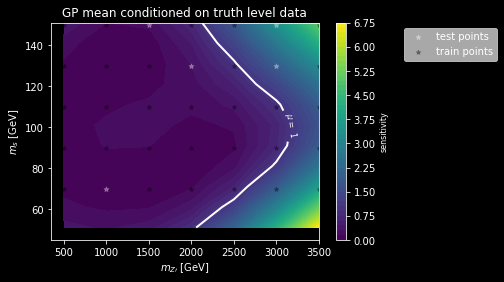

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import style
style.use('dark_background')


inverse_x_test = scaler.inverse_transform(X_test)
inverse_x_train = scaler.inverse_transform(X_train)
im = plt.contourf(X, Y, f_mean_grid.view(len(y), len(x)).cpu().numpy(), 50, alpha=1)
line  = plt.contour(X, Y,f_mean_grid.view(len(y), len(x)).cpu().numpy(),levels = [1.0], colors=('white'),linestyles=('-',),linewidths=(2,), label='predicted')
plt.clabel(line, fmt = '$\mu$ = %2.1d', colors = 'white', fontsize=8, inline=True) #contour line labels
plt.scatter(inverse_x_test[:,0], inverse_x_test[:,1], color='white', s=25, alpha=0.3, marker='*', label='test points')
plt.scatter(inverse_x_train[:,0], inverse_x_train[:,1], color='black', s=20,alpha=0.3, marker='*', label='train points')

cbar = plt.colorbar(im)
cbar.set_label('sensitivity',size=8)
plt.xlabel('$m_{Z\prime}$ [GeV]')
plt.ylabel('$m_s$ [GeV]')
plt.legend(bbox_to_anchor=(1.3,1), loc="upper left", facecolor='lightgrey')
plt.title('GP mean conditioned on truth level data')
plt.savefig('./mean_with_test_obs.pdf')

# Active Learning

In [ ]:
%pylab inline
%load_ext autoreload
%autoreload 2

In [31]:
np.warnings.filterwarnings('ignore')
import excursion